### **02 - Exploración Métrica AUC**
### **PROYECTO: DETECCIÓN HISTOPATOLÓGICA DEL CANCER**
### Funamentetos de Deep Learning - 2023-2

$ \mathcal{Daniel ~H. ~Martínez ~S. ~-~ UdeA} $

$ $

**Descripción del notebook:**

En este note book se estudia la separación de los datos train, val y test. Se crea un modelo de prueba para evaluar el comportamiento de diferentes métricas ellas el AUC, la matriz de confusión, entre otros.

In [1]:
# Librerias
# import opendatasets as od
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tempfile

from skimage import io
from pathlib import Path
from humanize import naturalsize
import tensorflow as tf
from tensorflow import keras
from tqdm.auto import tqdm
import h5py

import seaborn as sns
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from types import MethodWrapperType
from time import time

In [2]:
# Definitions
def Norm_img(img):
    # Normalización min-max
    return (img-np.min(img))/(np.max(img)-np.min(img))

def show_mosaic_class(train_labels,class_h,num_rand =5):
    # Mostrar mosaico para un rand dado
    num_class = len(class_h)
    for j in class_h:
      img_rand = np.random.choice(train_labels['id'][train_labels['label'] == j],num_rand)
      fig = plt.figure(figsize=(12,14))
      for i,k in enumerate(img_rand):
        ax = fig.add_subplot(num_class, num_rand, i+1)
        img = io.imread(k+'.tif')
        ax.imshow(Norm_img(img))
        if i == 0:
          ax.set(title = 'CLASS: '+str(j))

def rand_img(train_labels,class_h_,choose_ran = 'si',id='',show_plot = 'si'):
    if choose_ran == 'si':
      img_ = np.random.choice(train_labels['id'][train_labels['label'] == class_h_],1)
      img = io.imread(img_[0]+'.tif')
    elif choose_ran == 'no':
      img = io.imread(id+'.tif')
    if show_plot == 'si':
      fig, ax = plt.subplots(figsize = (5,4))
      ax.imshow(Norm_img(img))
      ax.set(title = 'CLASS: '+str(class_h_))
    plt.show()
    return img

def choose_img(train_labels,id,show_plot = 'si'):
    # Esoger imagen aleatoria para un clases dada
    img = io.imread(id+'.tif')
    if show_plot == 'si':
      fig, ax = plt.subplots(figsize = (5,4))
      ax.imshow(Norm_img(img))
      class_h_ = train_labels['label'][train_labels['id'] == id]
      class_h_ = class_h_.reset_index()
      print(class_h_)
      ax.set(title = 'Index: '+str(class_h_['index'].iloc[0])+' :--: CLASS: '+str(class_h_['label'].iloc[0]))
    plt.show();
    return img

def h5_w(path,N_img,data_ran):
    # Guardar archivo en formaro h5
    train_shape = (N_img,96,96,3)
    hf = h5py.File(path,'w')                            # Open a hdf5 file and create earrays
    hf.create_dataset('train_img',train_shape,np.uint8) #,compression="gzip", compression_opts=9)    # The pixels range is 0-255, dtype is uint
    for i,k in tqdm(enumerate(data_ran)):
      hf['train_img'][i,...] = choose_img(k, show_plot='no')
    hf.close()

def choose_img_label(h,choose_ran = 'si',show_plot = 'si',img_id=''):
    # Escoger imagen para un id dado o random
    if choose_ran == 'si':
      img_id = np.random.choice(np.arange(len(h)),1)[0]
      img = h[img_id]
    elif choose_ran == 'no':
      img = h[img_id]
    if show_plot == 'si':
      fig, ax = plt.subplots(figsize = (4,4))
      ax.imshow(Norm_img(img))
      if img_id < int(len(h)/2):
        class_h_ = 0
      else:
        class_h_ = 1
      ax.set(title = 'New index: '+str(img_id)+' :--: CLASS: '+str(class_h_))
    plt.show();
    return img

def load_data():
    !wget -nc https://github.com/DanielMartinez0/Proyecto_Deteccion_histopatologica_del_cancer/raw/main/data/H_c0_00.h5
    !wget -nc https://github.com/DanielMartinez0/Proyecto_Deteccion_histopatologica_del_cancer/raw/main/data/H_c0_01.h5
    !wget -nc https://github.com/DanielMartinez0/Proyecto_Deteccion_histopatologica_del_cancer/raw/main/data/H_c0_02.h5
    !wget -nc https://github.com/DanielMartinez0/Proyecto_Deteccion_histopatologica_del_cancer/raw/main/data/H_c1_00.h5
    !wget -nc https://github.com/DanielMartinez0/Proyecto_Deteccion_histopatologica_del_cancer/raw/main/data/H_c1_01.h5
    !wget -nc https://github.com/DanielMartinez0/Proyecto_Deteccion_histopatologica_del_cancer/raw/main/data/H_c1_02.h5
    path_train_labels ='https://raw.githubusercontent.com/DanielMartinez0/Proyecto_Deteccion_histopatologica_del_cancer/main/data/'
    train_hc = []
    for j in range(2):
      for i in range(3):
        file = 'H_c'+str(j)+'_0'+str(i)+'.h5'
        with h5py.File('/content/'+file,'r') as f:
          train_hc.append(f['train_img'][:])
    train_hc = np.r_[train_hc].reshape(int(6*900), 96, 96, 3)
    train_labels = pd.read_csv(path_train_labels+'train_labels.csv')
    return train_hc, train_labels

def train_val_test(train_hc,test_size=.25):
    # Asignación de clases para los datos cargados
    class_aux =[]
    for j in class_h:
      class_aux.append(j*np.ones(int(len(train_hc)/2)).astype(int))
    class_aux = np.array(class_aux).reshape(1,len(train_hc))
    x_train_ori, x_test, y_train, y_test = train_test_split(train_hc, class_aux[0], test_size=test_size)
    x_train, x_val, y_train, y_val = train_test_split(x_train_ori, y_train, test_size=test_size)
    print ('x_train, y_train:',x_train.shape, y_train.shape)
    print ('x_test, y_test:',x_test.shape, y_test.shape)
    print ('x_val, y_val:',x_val.shape, y_val.shape)
    print ("\n * Distribución de train classes: ")
    print (pd.Series(y_train).value_counts())
    print ("\n * Distribución of test classes: ")
    print (pd.Series(y_test).value_counts())
    print ("\n * Distribución of val classes: ")
    print (pd.Series(y_val).value_counts())
    return x_train,y_train, x_val,y_val, x_test,y_test

def norm255 (imgs):
    imgs = tf.cast(imgs,tf.float32)
    imgs /= 255  # 0-255 --> 0-1
    return imgs

def norm255_mm_auto(imgs):
  imgs = tf.cast(imgs,tf.float32)
  imgs = (imgs-imgs.numpy().min())/(imgs.numpy().max()-imgs.numpy().min())
  return imgs

def norm255_mm_man(imgs,vmin,vmax):
  imgs = tf.cast(imgs,tf.float32)
  imgs = (imgs-vmin)/(vmax-vmin)
  return imgs

def Metr():
  return([ keras.metrics.AUC(name='AUC'), keras.metrics.AUC(name='PRC', curve='PR'), keras.metrics.Recall(name='RECALL'),
          keras.metrics.MeanSquaredError(name='Mean Squared Error'), keras.metrics.TruePositives(name='Verdadero Positivo'),
          keras.metrics.FalsePositives(name='Falso Positivo'), keras.metrics.TrueNegatives(name='Verdadero Negativo'),
          keras.metrics.FalseNegatives(name='Falso Negativo'), keras.metrics.BinaryAccuracy(name='Accuracy'),
          keras.metrics.Precision(name='Precision')])

def bias_0(train_labels,print_desbal = 'si'):
  # Inicialización del BIAS
  neg, pos = np.bincount(train_labels['label']) # Desbalanceo de clases original
  total = neg + pos
  if print_desbal == 'si':
    print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(total, pos, 100 * pos / total))
  ini_bias = np.log([pos/neg])
  return ini_bias

def train(x_train, y_train,x_val, y_val,x_test,y_test,model, batch_size, epochs, model_name="",log_dir="logs/"):
    print('\n ::::::----- Inicio de Entrenamiento -----:::::: \n')
    # Generación de call-backs
    # early_stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc',
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

    # tensorboard
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir+model_name+"_"+"{}".format(time()))
    # model.reset_states()
    base_hist = model.fit(x_train, y_train, epochs=epochs, callbacks=[tensorboard,early_stopping],
              batch_size=batch_size,
              validation_data=(x_val, y_val))
    metrics2 = model.evaluate(x_test, y_test)
    dict_results = {k:v for k,v in zip (model.metrics_names, metrics2)}
    print(dict_results)
    return base_hist, dict_results

def plot_metrics(hist,metrics,col=3):
    fig = plt.figure(figsize=(15,6))
    for n, metric in enumerate(metrics):
      ax = fig.add_subplot(int(len(metrics)/col), col, n+1)
      ax.plot(hist.epoch, hist.history[metric], color='b', label='Train')
      ax.plot(hist.epoch, hist.history['val_'+metric], color='r', linestyle="--", label='Val')
      ax.set_xlabel('Epoch')
      ax.set_ylabel(metric)
      ax.legend()

def conf_matrix(labels, preds, ax,thres=0.5):
  C = confusion_matrix(labels, preds > thres)
  # plt.figure(figsize=(3,3))
  # ax = fig.add_subplot(1, 2, 1)
  sns.heatmap(C, annot=True, fmt="d")
  ax.set_title('Matriz de Confusión -- Umbral: {:.2f}'.format(thres))
  ax.set_ylabel('Etiqueta real')
  ax.set_xlabel('Etiqueta predicha')
  print('\n')
  print('--> Imágenes SIN cancer detectadas NEGATIVA :: CORRECTAMENTE (VERDADEROS NEGATIVOS): ', C[0][0])
  print('--> Imágenes SIN cancer detectada como POSITIVA :: INCORRECTAMENTE (FALSOS POSITIVOS): ', C[0][1])
  print('--> Imágenes CON cancer detectadas como NEGATIVA :: INCORRECTAMENTE (FALSOS NEGATIVOS): ', C[1][0])
  print('--> Imágenes CON cancer detectadas POSITIVA :: CORRECTAMENTE (VERDADEROS POSITIVOS): ', C[1][1])
  print('\n')

def ROC(name, labels, pred,ax, **kwargs):
  Fal_Pos, Ver_Pos, _ = sklearn.metrics.roc_curve(labels, pred)
  # ax = fig.add_subplot(1, 2, 2)
  ax.plot(100*Fal_Pos, 100*Ver_Pos, label=name, linewidth=2, **kwargs)
  plt.xlabel('Falsos Positivos [%]')
  plt.ylabel('Verdaderos Positivos [%]')
  plt.grid(True)
  plt.title('Curva ROC')

def medidas_AUC(model_A,base_hist,metrics,x_train,x_test,batch_size):
    plot_metrics(base_hist,metrics)
    # Evaluación de las métricas
    print('...Calculando valores predichos para train y test: ...')
    y_train_predict = model_A.predict(x_train, batch_size=batch_size)
    y_test_predict = model_A.predict(x_test, batch_size=batch_size)

    Results = model_A.evaluate(x_test, y_test, batch_size=batch_size, verbose=0)
    print('\n ** Resultados de las métricas:...')
    for name, value in zip(model_A.metrics_names, Results):
      print(name, ': ', value)

    # fig, ax = plt.subplots(figsize = (12,4))
    fig = plt.figure(figsize=(12,4))

    ax = fig.add_subplot(1, 2, 1)
    # Matriz de confuxión
    conf_matrix(y_test, y_test_predict,ax)

    ax = fig.add_subplot(1, 2, 2)
    # Curva ROC
    ROC("Train ", y_train, y_train_predict,ax, color='b',marker='.')
    ROC("Test ", y_test, y_test_predict,ax, color='r', linestyle='--',marker='.')
    plt.legend(loc='best'); # 'lower right'

## Cargar dataset

In [3]:
train_hc, train_labels = load_data()
class_h = train_labels['label'].unique()
num_class = len(class_h)

--2023-11-17 04:14:54--  https://github.com/DanielMartinez0/Proyecto_Deteccion_histopatologica_del_cancer/raw/main/data/H_c0_00.h5
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/DanielMartinez0/Proyecto_Deteccion_histopatologica_del_cancer/main/data/H_c0_00.h5 [following]
--2023-11-17 04:14:55--  https://raw.githubusercontent.com/DanielMartinez0/Proyecto_Deteccion_histopatologica_del_cancer/main/data/H_c0_00.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24885248 (24M) [application/octet-stream]
Saving to: ‘H_c0_00.h5’

H_c0_00.h5          100%[===================>]  23.73M  96.4MB/s    in 

### Datos `train`, `val` y `test`

In [4]:
x_train,y_train, x_val,y_val, x_test,y_test = train_val_test(train_hc) #,test_size=.25)

x_train, y_train: (3037, 96, 96, 3) (3037,)
x_test, y_test: (1350, 96, 96, 3) (1350,)
x_val, y_val: (1013, 96, 96, 3) (1013,)

 * Distribución de train classes: 
1    1521
0    1516
dtype: int64

 * Distribución of test classes: 
1    675
0    675
dtype: int64

 * Distribución of val classes: 
0    509
1    504
dtype: int64


### Normalización de los datos

In [5]:
# x_train_N = norm255(x_train)
# x_val_N  = norm255(x_val)
# x_test_N  = norm255(x_test)

x_train_N = norm255_mm_auto(x_train)
x_val_N  = norm255_mm_auto(x_val)
x_test_N  = norm255_mm_auto(x_test)

x_train_N.shape, x_val_N.shape, x_test_N.shape

(TensorShape([3037, 96, 96, 3]),
 TensorShape([1013, 96, 96, 3]),
 TensorShape([1350, 96, 96, 3]))

## Prueba - Modelo A

Clasificador Biclase
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 flatten (Flatten)           (None, 27648)             0         
                                                                 
 densa_1 (Dense)             (None, 100)               2764900   
                                                                 
 densa_2 (Dense)             (None, 50)                5050      
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 output (Dense)              (None, 1)                 51        
                                                                 
Total params: 2770001 (10.57 MB)
Trainab

95/95 [==============================] - 4s 15ms/step - loss: 271.5325 - AUC: 0.5150 - PRC: 0.5117 - RECALL: 0.5253 - Mean Squared Error: 0.4846 - Verdadero Positivo: 799.0000 - Falso Positivo: 753.0000 - Verdadero Negativo: 763.0000 - Falso Negativo: 722.0000 - Accuracy: 0.5143 - Precision: 0.5148 - val_loss: 31.9184 - val_AUC: 0.5020 - val_PRC: 0.4985 - val_RECALL: 1.0000 - val_Mean Squared Error: 0.5005 - val_Verdadero Positivo: 504.0000 - val_Falso Positivo: 507.0000 - val_Verdadero Negativo: 2.0000 - val_Falso Negativo: 0.0000e+00 - val_Accuracy: 0.4995 - val_Precision: 0.4985
Epoch 2/20
93/95 [============================>.] - ETA: 0s - loss: 14.9577 - AUC: 0.5207 - PRC: 0.5203 - RECALL: 0.4568 - Mean Squared Error: 0.4299 - Verdadero Positivo: 682.0000 - Falso Positivo: 640.0000 - Verdadero Negativo: 843.0000 - Falso Negativo: 811.0000 - Accuracy: 0.5124 - Precision: 0.5159

95/95 [==============================] - 1s 9ms/step - loss: 14.6714 - AUC: 0.5202 - PRC: 0.5194 - RECALL: 0.4497 - Mean Squared Error: 0.4264 - Verdadero Positivo: 684.0000 - Falso Positivo: 645.0000 - Verdadero Negativo: 871.0000 - Falso Negativo: 837.0000 - Accuracy: 0.5120 - Precision: 0.5147 - val_loss: 0.6962 - val_AUC: 0.5037 - val_PRC: 0.4734 - val_RECALL: 0.0000e+00 - val_Mean Squared Error: 0.2515 - val_Verdadero Positivo: 0.0000e+00 - val_Falso Positivo: 0.0000e+00 - val_Verdadero Negativo: 509.0000 - val_Falso Negativo: 504.0000 - val_Accuracy: 0.5025 - val_Precision: 0.0000e+00
Epoch 3/20
89/95 [===========================>..] - ETA: 0s - loss: 0.7586 - AUC: 0.5020 - PRC: 0.4963 - RECALL: 0.5659 - Mean Squared Error: 0.2767 - Verdadero Positivo: 803.0000 - Falso Positivo: 811.0000 - Verdadero Negativo: 618.0000 - Falso Negativo: 616.0000 - Accuracy: 0.4989 - Precision: 0.4975

95/95 [==============================] - 1s 9ms/step - loss: 0.7573 - AUC: 0.5024 - PRC: 0.4982 - RECALL: 0.5832 - Mean Squared Error: 0.2762 - Verdadero Positivo: 887.0000 - Falso Positivo: 889.0000 - Verdadero Negativo: 627.0000 - Falso Negativo: 634.0000 - Accuracy: 0.4985 - Precision: 0.4994 - val_loss: 0.7007 - val_AUC: 0.5439 - val_PRC: 0.4774 - val_RECALL: 0.0000e+00 - val_Mean Squared Error: 0.2538 - val_Verdadero Positivo: 0.0000e+00 - val_Falso Positivo: 0.0000e+00 - val_Verdadero Negativo: 509.0000 - val_Falso Negativo: 504.0000 - val_Accuracy: 0.5025 - val_Precision: 0.0000e+00
Epoch 4/20
92/95 [============================>.] - ETA: 0s - loss: 1.3489 - AUC: 0.4960 - PRC: 0.4929 - RECALL: 0.5448 - Mean Squared Error: 0.3043 - Verdadero Positivo: 803.0000 - Falso Positivo: 790.0000 - Verdadero Negativo: 680.0000 - Falso Negativo: 671.0000 - Accuracy: 0.5037 - Precision: 0.5041

95/95 [==============================] - 1s 9ms/step - loss: 1.3286 - AUC: 0.4972 - PRC: 0.4939 - RECALL: 0.5588 - Mean Squared Error: 0.3025 - Verdadero Positivo: 850.0000 - Falso Positivo: 830.0000 - Verdadero Negativo: 686.0000 - Falso Negativo: 671.0000 - Accuracy: 0.5058 - Precision: 0.5060 - val_loss: 0.7172 - val_AUC: 0.5276 - val_PRC: 0.4676 - val_RECALL: 1.0000 - val_Mean Squared Error: 0.2617 - val_Verdadero Positivo: 504.0000 - val_Falso Positivo: 509.0000 - val_Verdadero Negativo: 0.0000e+00 - val_Falso Negativo: 0.0000e+00 - val_Accuracy: 0.4975 - val_Precision: 0.4975
Epoch 5/20
89/95 [===========================>..] - ETA: 0s - loss: 0.7040 - AUC: 0.5572 - PRC: 0.5464 - RECALL: 0.6084 - Mean Squared Error: 0.2542 - Verdadero Positivo: 870.0000 - Falso Positivo: 780.0000 - Verdadero Negativo: 638.0000 - Falso Negativo: 560.0000 - Accuracy: 0.5295 - Precision: 0.5273

95/95 [==============================] - 1s 9ms/step - loss: 0.7172 - AUC: 0.5593 - PRC: 0.5436 - RECALL: 0.6279 - Mean Squared Error: 0.2555 - Verdadero Positivo: 955.0000 - Falso Positivo: 856.0000 - Verdadero Negativo: 660.0000 - Falso Negativo: 566.0000 - Accuracy: 0.5318 - Precision: 0.5273 - val_loss: 0.6963 - val_AUC: 0.7030 - val_PRC: 0.6675 - val_RECALL: 1.0000 - val_Mean Squared Error: 0.2517 - val_Verdadero Positivo: 504.0000 - val_Falso Positivo: 509.0000 - val_Verdadero Negativo: 0.0000e+00 - val_Falso Negativo: 0.0000e+00 - val_Accuracy: 0.4975 - val_Precision: 0.4975
Epoch 6/20
90/95 [===========================>..] - ETA: 0s - loss: 0.6953 - AUC: 0.5558 - PRC: 0.5544 - RECALL: 0.6134 - Mean Squared Error: 0.2508 - Verdadero Positivo: 887.0000 - Falso Positivo: 787.0000 - Verdadero Negativo: 647.0000 - Falso Negativo: 559.0000 - Accuracy: 0.5326 - Precision: 0.5299

95/95 [==============================] - 1s 9ms/step - loss: 0.6950 - AUC: 0.5548 - PRC: 0.5527 - RECALL: 0.6036 - Mean Squared Error: 0.2507 - Verdadero Positivo: 918.0000 - Falso Positivo: 820.0000 - Verdadero Negativo: 696.0000 - Falso Negativo: 603.0000 - Accuracy: 0.5314 - Precision: 0.5282 - val_loss: 0.6746 - val_AUC: 0.6793 - val_PRC: 0.6335 - val_RECALL: 0.9504 - val_Mean Squared Error: 0.2408 - val_Verdadero Positivo: 479.0000 - val_Falso Positivo: 364.0000 - val_Verdadero Negativo: 145.0000 - val_Falso Negativo: 25.0000 - val_Accuracy: 0.6160 - val_Precision: 0.5682
Epoch 7/20
92/95 [============================>.] - ETA: 0s - loss: 0.6928 - AUC: 0.5684 - PRC: 0.5577 - RECALL: 0.6286 - Mean Squared Error: 0.2495 - Verdadero Positivo: 929.0000 - Falso Positivo: 783.0000 - Verdadero Negativo: 683.0000 - Falso Negativo: 549.0000 - Accuracy: 0.5476 - Precision: 0.5426

95/95 [==============================] - 1s 12ms/step - loss: 0.6930 - AUC: 0.5667 - PRC: 0.5562 - RECALL: 0.6206 - Mean Squared Error: 0.2496 - Verdadero Positivo: 944.0000 - Falso Positivo: 806.0000 - Verdadero Negativo: 710.0000 - Falso Negativo: 577.0000 - Accuracy: 0.5446 - Precision: 0.5394 - val_loss: 0.6663 - val_AUC: 0.6669 - val_PRC: 0.6169 - val_RECALL: 0.7321 - val_Mean Squared Error: 0.2367 - val_Verdadero Positivo: 369.0000 - val_Falso Positivo: 253.0000 - val_Verdadero Negativo: 256.0000 - val_Falso Negativo: 135.0000 - val_Accuracy: 0.6170 - val_Precision: 0.5932
Epoch 8/20
95/95 [==============================] - ETA: 0s - loss: 0.6943 - AUC: 0.5693 - PRC: 0.5762 - RECALL: 0.6305 - Mean Squared Error: 0.2504 - Verdadero Positivo: 959.0000 - Falso Positivo: 850.0000 - Verdadero Negativo: 666.0000 - Falso Negativo: 562.0000 - Accuracy: 0.5351 - Precision: 0.5301

95/95 [==============================] - 1s 12ms/step - loss: 0.6943 - AUC: 0.5693 - PRC: 0.5762 - RECALL: 0.6305 - Mean Squared Error: 0.2504 - Verdadero Positivo: 959.0000 - Falso Positivo: 850.0000 - Verdadero Negativo: 666.0000 - Falso Negativo: 562.0000 - Accuracy: 0.5351 - Precision: 0.5301 - val_loss: 0.6997 - val_AUC: 0.4613 - val_PRC: 0.4822 - val_RECALL: 1.0000 - val_Mean Squared Error: 0.2533 - val_Verdadero Positivo: 504.0000 - val_Falso Positivo: 509.0000 - val_Verdadero Negativo: 0.0000e+00 - val_Falso Negativo: 0.0000e+00 - val_Accuracy: 0.4975 - val_Precision: 0.4975
Epoch 9/20
95/95 [==============================] - ETA: 0s - loss: 0.6879 - AUC: 0.5773 - PRC: 0.5822 - RECALL: 0.6377 - Mean Squared Error: 0.2473 - Verdadero Positivo: 970.0000 - Falso Positivo: 837.0000 - Verdadero Negativo: 679.0000 - Falso Negativo: 551.0000 - Accuracy: 0.5430 - Precision: 0.5368

95/95 [==============================] - 1s 13ms/step - loss: 0.6879 - AUC: 0.5773 - PRC: 0.5822 - RECALL: 0.6377 - Mean Squared Error: 0.2473 - Verdadero Positivo: 970.0000 - Falso Positivo: 837.0000 - Verdadero Negativo: 679.0000 - Falso Negativo: 551.0000 - Accuracy: 0.5430 - Precision: 0.5368 - val_loss: 0.6865 - val_AUC: 0.6459 - val_PRC: 0.6229 - val_RECALL: 1.0000 - val_Mean Squared Error: 0.2468 - val_Verdadero Positivo: 504.0000 - val_Falso Positivo: 509.0000 - val_Verdadero Negativo: 0.0000e+00 - val_Falso Negativo: 0.0000e+00 - val_Accuracy: 0.4975 - val_Precision: 0.4975
Epoch 10/20
95/95 [==============================] - ETA: 0s - loss: 0.6784 - AUC: 0.6069 - PRC: 0.5980 - RECALL: 0.6325 - Mean Squared Error: 0.2427 - Verdadero Positivo: 962.0000 - Falso Positivo: 702.0000 - Verdadero Negativo: 814.0000 - Falso Negativo: 559.0000 - Accuracy: 0.5848 - Precision: 0.5781

95/95 [==============================] - 1s 13ms/step - loss: 0.6784 - AUC: 0.6069 - PRC: 0.5980 - RECALL: 0.6325 - Mean Squared Error: 0.2427 - Verdadero Positivo: 962.0000 - Falso Positivo: 702.0000 - Verdadero Negativo: 814.0000 - Falso Negativo: 559.0000 - Accuracy: 0.5848 - Precision: 0.5781 - val_loss: 0.6667 - val_AUC: 0.6498 - val_PRC: 0.5964 - val_RECALL: 0.3135 - val_Mean Squared Error: 0.2378 - val_Verdadero Positivo: 158.0000 - val_Falso Positivo: 110.0000 - val_Verdadero Negativo: 399.0000 - val_Falso Negativo: 346.0000 - val_Accuracy: 0.5499 - val_Precision: 0.5896
Epoch 11/20
93/95 [============================>.] - ETA: 0s - loss: 0.7069 - AUC: 0.5743 - PRC: 0.5771 - RECALL: 0.5534 - Mean Squared Error: 0.2550 - Verdadero Positivo: 829.0000 - Falso Positivo: 646.0000 - Verdadero Negativo: 832.0000 - Falso Negativo: 669.0000 - Accuracy: 0.5581 - Precision: 0.5620

95/95 [==============================] - 1s 9ms/step - loss: 0.7065 - AUC: 0.5740 - PRC: 0.5748 - RECALL: 0.5510 - Mean Squared Error: 0.2548 - Verdadero Positivo: 838.0000 - Falso Positivo: 659.0000 - Verdadero Negativo: 857.0000 - Falso Negativo: 683.0000 - Accuracy: 0.5581 - Precision: 0.5598 - val_loss: 0.6628 - val_AUC: 0.6610 - val_PRC: 0.6111 - val_RECALL: 0.5556 - val_Mean Squared Error: 0.2351 - val_Verdadero Positivo: 280.0000 - val_Falso Positivo: 175.0000 - val_Verdadero Negativo: 334.0000 - val_Falso Negativo: 224.0000 - val_Accuracy: 0.6061 - val_Precision: 0.6154
Epoch 12/20
92/95 [============================>.] - ETA: 0s - loss: 0.6711 - AUC: 0.6192 - PRC: 0.6138 - RECALL: 0.5919 - Mean Squared Error: 0.2392 - Verdadero Positivo: 873.0000 - Falso Positivo: 634.0000 - Verdadero Negativo: 835.0000 - Falso Negativo: 602.0000 - Accuracy: 0.5802 - Precision: 0.5793

95/95 [==============================] - 1s 10ms/step - loss: 0.6698 - AUC: 0.6225 - PRC: 0.6162 - RECALL: 0.5950 - Mean Squared Error: 0.2386 - Verdadero Positivo: 905.0000 - Falso Positivo: 652.0000 - Verdadero Negativo: 864.0000 - Falso Negativo: 616.0000 - Accuracy: 0.5825 - Precision: 0.5812 - val_loss: 0.6496 - val_AUC: 0.6717 - val_PRC: 0.6216 - val_RECALL: 0.7103 - val_Mean Squared Error: 0.2287 - val_Verdadero Positivo: 358.0000 - val_Falso Positivo: 237.0000 - val_Verdadero Negativo: 272.0000 - val_Falso Negativo: 146.0000 - val_Accuracy: 0.6219 - val_Precision: 0.6017
Epoch 13/20
92/95 [============================>.] - ETA: 0s - loss: 0.6743 - AUC: 0.6123 - PRC: 0.6054 - RECALL: 0.6028 - Mean Squared Error: 0.2407 - Verdadero Positivo: 891.0000 - Falso Positivo: 647.0000 - Verdadero Negativo: 819.0000 - Falso Negativo: 587.0000 - Accuracy: 0.5808 - Precision: 0.5793

95/95 [==============================] - 1s 9ms/step - loss: 0.6747 - AUC: 0.6109 - PRC: 0.6043 - RECALL: 0.5930 - Mean Squared Error: 0.2410 - Verdadero Positivo: 902.0000 - Falso Positivo: 657.0000 - Verdadero Negativo: 859.0000 - Falso Negativo: 619.0000 - Accuracy: 0.5798 - Precision: 0.5786 - val_loss: 0.6960 - val_AUC: 0.6306 - val_PRC: 0.5813 - val_RECALL: 0.1528 - val_Mean Squared Error: 0.2516 - val_Verdadero Positivo: 77.0000 - val_Falso Positivo: 59.0000 - val_Verdadero Negativo: 450.0000 - val_Falso Negativo: 427.0000 - val_Accuracy: 0.5202 - val_Precision: 0.5662
Epoch 14/20
92/95 [============================>.] - ETA: 0s - loss: 0.6776 - AUC: 0.6037 - PRC: 0.6168 - RECALL: 0.5940 - Mean Squared Error: 0.2426 - Verdadero Positivo: 878.0000 - Falso Positivo: 656.0000 - Verdadero Negativo: 810.0000 - Falso Negativo: 600.0000 - Accuracy: 0.5734 - Precision: 0.5724

95/95 [==============================] - 1s 9ms/step - loss: 0.6774 - AUC: 0.6038 - PRC: 0.6153 - RECALL: 0.5891 - Mean Squared Error: 0.2424 - Verdadero Positivo: 896.0000 - Falso Positivo: 667.0000 - Verdadero Negativo: 849.0000 - Falso Negativo: 625.0000 - Accuracy: 0.5746 - Precision: 0.5733 - val_loss: 0.6787 - val_AUC: 0.6459 - val_PRC: 0.6010 - val_RECALL: 0.4345 - val_Mean Squared Error: 0.2428 - val_Verdadero Positivo: 219.0000 - val_Falso Positivo: 136.0000 - val_Verdadero Negativo: 373.0000 - val_Falso Negativo: 285.0000 - val_Accuracy: 0.5844 - val_Precision: 0.6169
Epoch 15/20
90/95 [===========================>..] - ETA: 0s - loss: 0.6714 - AUC: 0.6172 - PRC: 0.6235 - RECALL: 0.5901 - Mean Squared Error: 0.2394 - Verdadero Positivo: 848.0000 - Falso Positivo: 596.0000 - Verdadero Negativo: 847.0000 - Falso Negativo: 589.0000 - Accuracy: 0.5885 - Precision: 0.5873

95/95 [==============================] - 1s 9ms/step - loss: 0.6697 - AUC: 0.6210 - PRC: 0.6302 - RECALL: 0.5976 - Mean Squared Error: 0.2386 - Verdadero Positivo: 909.0000 - Falso Positivo: 634.0000 - Verdadero Negativo: 882.0000 - Falso Negativo: 612.0000 - Accuracy: 0.5897 - Precision: 0.5891 - val_loss: 0.6591 - val_AUC: 0.6687 - val_PRC: 0.6175 - val_RECALL: 0.6468 - val_Mean Squared Error: 0.2332 - val_Verdadero Positivo: 326.0000 - val_Falso Positivo: 208.0000 - val_Verdadero Negativo: 301.0000 - val_Falso Negativo: 178.0000 - val_Accuracy: 0.6190 - val_Precision: 0.6105
Epoch 16/20
89/95 [===========================>..] - ETA: 0s - loss: 0.6748 - AUC: 0.6114 - PRC: 0.6088 - RECALL: 0.5768 - Mean Squared Error: 0.2411 - Verdadero Positivo: 822.0000 - Falso Positivo: 624.0000 - Verdadero Negativo: 799.0000 - Falso Negativo: 603.0000 - Accuracy: 0.5692 - Precision: 0.5685

95/95 [==============================] - 1s 9ms/step - loss: 0.6741 - AUC: 0.6126 - PRC: 0.6105 - RECALL: 0.5641 - Mean Squared Error: 0.2407 - Verdadero Positivo: 858.0000 - Falso Positivo: 645.0000 - Verdadero Negativo: 871.0000 - Falso Negativo: 663.0000 - Accuracy: 0.5693 - Precision: 0.5709 - val_loss: 0.6798 - val_AUC: 0.6411 - val_PRC: 0.5938 - val_RECALL: 0.2579 - val_Mean Squared Error: 0.2435 - val_Verdadero Positivo: 130.0000 - val_Falso Positivo: 92.0000 - val_Verdadero Negativo: 417.0000 - val_Falso Negativo: 374.0000 - val_Accuracy: 0.5400 - val_Precision: 0.5856
Epoch 17/20
92/95 [============================>.] - ETA: 0s - loss: 0.6626 - AUC: 0.6332 - PRC: 0.6313 - RECALL: 0.5422 - Mean Squared Error: 0.2353 - Verdadero Positivo: 803.0000 - Falso Positivo: 516.0000 - Verdadero Negativo: 947.0000 - Falso Negativo: 678.0000 - Accuracy: 0.5944 - Precision: 0.6088

95/95 [==============================] - 1s 9ms/step - loss: 0.6639 - AUC: 0.6298 - PRC: 0.6274 - RECALL: 0.5358 - Mean Squared Error: 0.2359 - Verdadero Positivo: 815.0000 - Falso Positivo: 532.0000 - Verdadero Negativo: 984.0000 - Falso Negativo: 706.0000 - Accuracy: 0.5924 - Precision: 0.6050 - val_loss: 0.6826 - val_AUC: 0.6373 - val_PRC: 0.5915 - val_RECALL: 0.2857 - val_Mean Squared Error: 0.2448 - val_Verdadero Positivo: 144.0000 - val_Falso Positivo: 97.0000 - val_Verdadero Negativo: 412.0000 - val_Falso Negativo: 360.0000 - val_Accuracy: 0.5489 - val_Precision: 0.5975
Epoch 18/20
90/95 [===========================>..] - ETA: 0s - loss: 0.6787 - AUC: 0.5954 - PRC: 0.6002 - RECALL: 0.4266 - Mean Squared Error: 0.2414 - Verdadero Positivo: 613.0000 - Falso Positivo: 435.0000 - Verdadero Negativo: 1008.0000 - Falso Negativo: 824.0000 - Accuracy: 0.5628 - Precision: 0.5849

95/95 [==============================] - 1s 9ms/step - loss: 0.6787 - AUC: 0.5957 - PRC: 0.6011 - RECALL: 0.4241 - Mean Squared Error: 0.2414 - Verdadero Positivo: 645.0000 - Falso Positivo: 454.0000 - Verdadero Negativo: 1062.0000 - Falso Negativo: 876.0000 - Accuracy: 0.5621 - Precision: 0.5869 - val_loss: 0.6762 - val_AUC: 0.6461 - val_PRC: 0.5934 - val_RECALL: 0.3393 - val_Mean Squared Error: 0.2417 - val_Verdadero Positivo: 171.0000 - val_Falso Positivo: 110.0000 - val_Verdadero Negativo: 399.0000 - val_Falso Negativo: 333.0000 - val_Accuracy: 0.5627 - val_Precision: 0.6085
Epoch 19/20
90/95 [===========================>..] - ETA: 0s - loss: 0.6658 - AUC: 0.6273 - PRC: 0.6390 - RECALL: 0.5461 - Mean Squared Error: 0.2369 - Verdadero Positivo: 794.0000 - Falso Positivo: 524.0000 - Verdadero Negativo: 902.0000 - Falso Negativo: 660.0000 - Accuracy: 0.5889 - Precision: 0.6024

95/95 [==============================] - 1s 9ms/step - loss: 0.6647 - AUC: 0.6312 - PRC: 0.6371 - RECALL: 0.5523 - Mean Squared Error: 0.2363 - Verdadero Positivo: 840.0000 - Falso Positivo: 557.0000 - Verdadero Negativo: 959.0000 - Falso Negativo: 681.0000 - Accuracy: 0.5924 - Precision: 0.6013 - val_loss: 0.6769 - val_AUC: 0.6471 - val_PRC: 0.5925 - val_RECALL: 0.2857 - val_Mean Squared Error: 0.2422 - val_Verdadero Positivo: 144.0000 - val_Falso Positivo: 97.0000 - val_Verdadero Negativo: 412.0000 - val_Falso Negativo: 360.0000 - val_Accuracy: 0.5489 - val_Precision: 0.5975
Epoch 20/20
87/95 [==========================>...] - ETA: 0s - loss: 0.6692 - AUC: 0.6188 - PRC: 0.6129 - RECALL: 0.4964 - Mean Squared Error: 0.2384 - Verdadero Positivo: 694.0000 - Falso Positivo: 477.0000 - Verdadero Negativo: 909.0000 - Falso Negativo: 704.0000 - Accuracy: 0.5758 - Precision: 0.5927

43/43 [==============================] - 0s 7ms/step - loss: 0.6651 - AUC: 0.6475 - PRC: 0.6111 - RECALL: 0.5896 - Mean Squared Error: 0.2362 - Verdadero Positivo: 398.0000 - Falso Positivo: 269.0000 - Verdadero Negativo: 406.0000 - Falso Negativo: 277.0000 - Accuracy: 0.5956 - Precision: 0.5967
{'loss': 0.6650847792625427, 'AUC': 0.6475390791893005, 'PRC': 0.6111093759536743, 'RECALL': 0.5896296501159668, 'Mean Squared Error': 0.23620478808879852, 'Verdadero Positivo': 398.0, 'Falso Positivo': 269.0, 'Verdadero Negativo': 406.0, 'Falso Negativo': 277.0, 'Accuracy': 0.5955555438995361, 'Precision': 0.5967016220092773}
...Calculando valores predichos para train y test: ...
43/43 [==============================] - 0s 3ms/step

 ** Resultados de las métricas:...
loss :  0.6650847792625427
AUC :  0.6475390791893005
PRC :  0.6111093759536743
RECALL :  0.5896296501159668
Mean Squared Error :  0.23620478808879852
Verdadero Positivo :  398.0
Falso Positivo :  269.0
Verdadero Negativo :  406.0


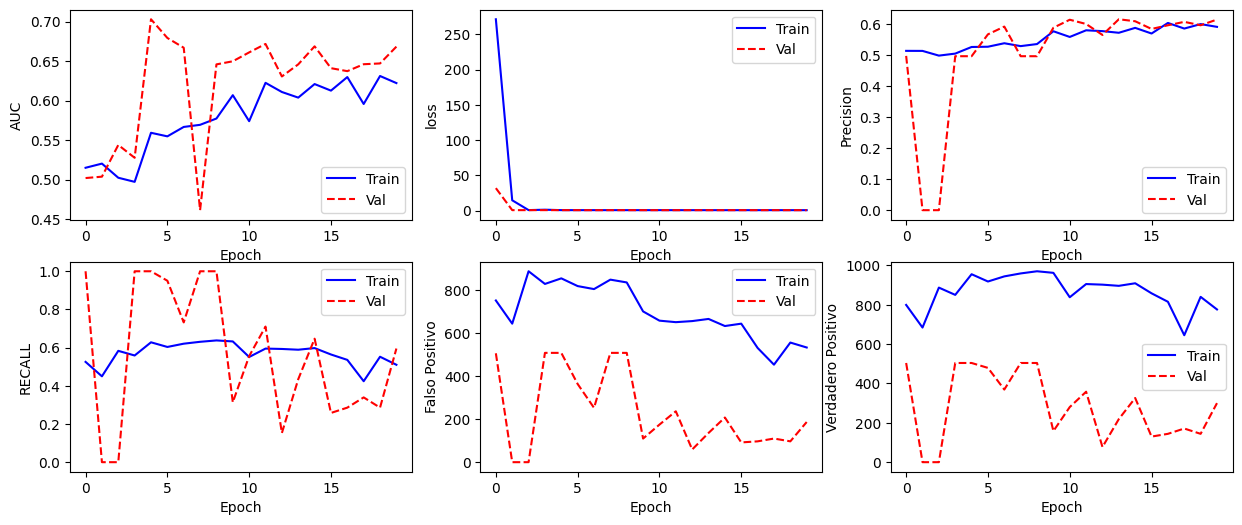

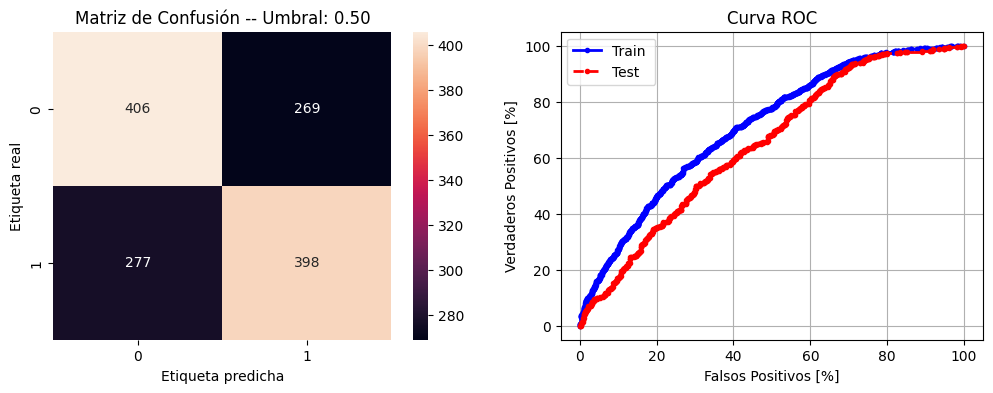

In [12]:
def get_model_A(img_size=96, compile=True,output_bias=None):

    tf.keras.backend.clear_session()
    print ("Clasificador Biclase")

    if output_bias is not None:
      output_bias = tf.keras.initializers.Constant(output_bias)

    # Capa de entrada, decimos que vamos a tener imagenes de 96x96x3
    inputs = tf.keras.Input(shape=(img_size,img_size,3), name="input")

    # Capa convolucional: 15 filtros, de 3x3, padding="SAME" para que el tamaño de la salida sea el mismo que la entrada
    # layers = tf.keras.layers.Conv2D(15,(3,3), activation="relu", padding="SAME")(inputs)

    # Provemos ingresando una flatten despues de la entrada
    layers = tf.keras.layers.Flatten()(inputs)

    # Densa 2
    layers = tf.keras.layers.Dense(100, activation=tf.nn.relu, name="densa_1")(layers)
    layers = tf.keras.layers.Dense(50, activation=tf.nn.relu, name="densa_2")(layers)

    # # Transición fully-conected, para que sea compatible con una densa
    # layers = tf.keras.layers.Flatten()(layers)

    # # Capas densas
    # layers = tf.keras.layers.Dense(48, activation=tf.nn.relu)(layers)
    # layers = tf.keras.layers.Dense(24, activation=tf.nn.relu)(layers)
    # layers = tf.keras.layers.Dense(12, activation=tf.nn.relu)(layers)

    # # Dropout
    layers = tf.keras.layers.Dropout(0.2)(layers)
    predict= tf.keras.layers.Dense(1, activation=tf.nn.sigmoid, name="output")(layers)  # tf.nn.softmax
    model = tf.keras.Model(inputs = inputs, outputs=predict)
    if compile:
        model.compile(optimizer='adam',
                      loss= tf.keras.losses.BinaryCrossentropy(), #'sparse_categorical_crossentropy',
                      metrics=Metr())
    return model

model_A = get_model_A(output_bias=bias_0(train_labels,print_desbal = 'no'))  # Inicialización del bias
model_A.summary()

model_name="model_A_v1"
log_dir="logs/v3/"
batch_size=32
base_hist, dict_results = train(x_train, y_train,x_val, y_val,x_test,y_test,model_A, batch_size=batch_size,
                                epochs=20, model_name=model_name,log_dir=log_dir)
# Gráficas y Métricas
metrics = ['AUC','loss', 'Precision', 'RECALL','Falso Positivo','Verdadero Positivo']
medidas_AUC(model_A,base_hist,metrics,x_train,x_test,batch_size)